# Notebook SVM linéaire

In [ ]:
# Décommenter à la première utilisation du notebook, puis commenter ensuite
#!pip3 install sklearn

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

## Affichage

In [2]:
def set_default(figsize=(7, 4), dpi=100):

    plt.style.use(['fivethirtyeight'])

    plt.rc('figure', figsize=figsize,dpi=dpi)
    plt.rcParams['axes.labelsize'] = 12
        
    plt.rcParams['text.color'] = 'black'

    plt.rcParams['lines.linewidth'] = 1
    plt.rcParams['xtick.labelsize'] = 10
    plt.rcParams['ytick.labelsize'] = 10
    plt.rcParams['savefig.bbox'] = 'tight'
    plt.rcParams['legend.frameon'] = False
    
    plt.rc('font', family='serif')

def set_aspect(ax):
    options = {"head_width":0.1, "head_length":0.2, "length_includes_head":True}
    ax.spines['left'].set_position(('data', 0))
    ax.spines['bottom'].set_position(('data', 0))
    ax.spines['right'].set_position(('data', -1))
    ax.spines['top'].set_position(('data', -1))
    ax.grid(True,ls=':')

In [3]:
set_default()

<a name='donnees'></a>

## Données

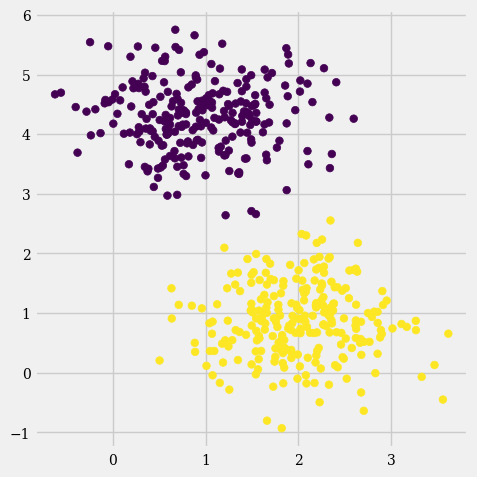

In [4]:
from sklearn.datasets import make_blobs
Xblobs, yblobs = make_blobs(n_samples=500, centers=2,random_state=0, cluster_std=0.6)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(Xblobs[:, 0], Xblobs[:, 1], c=yblobs, s=30);
plt.tight_layout()

Pour la génération de données non linéairement séparables, on utilise les fonctions make_moons et make_circle

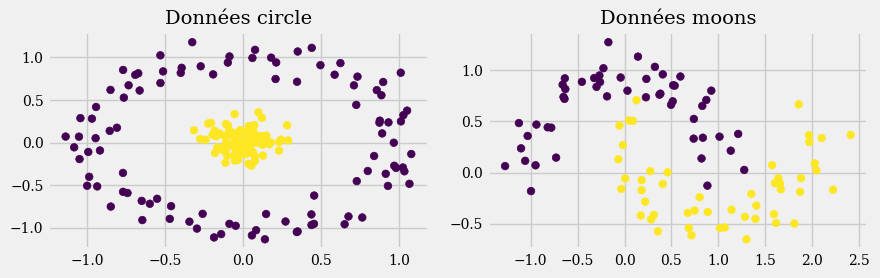

In [5]:
from sklearn.datasets import make_moons,make_circles
Xmoons, ymoons = make_moons(n_samples=100, noise=0.15, random_state=42)
Xcircle, ycircle = make_circles(200, factor=.1, noise=.1)


fig, ax = plt.subplots(1, 2, figsize=(9, 3))
ax[0].scatter(Xcircle[:, 0], Xcircle[:, 1], c=ycircle, s=30)
ax[0].set_title("Données circle",fontsize=14)
ax[1].scatter(Xmoons[:, 0], Xmoons[:, 1], c=ymoons, s=30)
ax[1].set_title("Données moons",fontsize=14)
plt.tight_layout()

On définit une fonction qui affiche la frontière de décision d'un classifieur

In [6]:
def plot_svc_frontiere(model, ax=None, plot_support=True):
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # Frontière et marges
    ax.contour(X, Y, P, colors='r',levels=[-1, 0, 1], alpha=0.5,linestyles=['--', '-', '--'])
    
    # Vecteurs support
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],model.support_vectors_[:, 1],
                   s=200,linewidth=1,facecolors='none',edgecolors='r');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

# Séparation linéaire

On recherche une séparation linéaire $f$ entre les deux classes. Dans le cas de données linéairement séparables, il existe une infinité de séparateurs linéaires et, par exemple pour le jeu de données 2D  précédent on peut construire les droites candidates : 

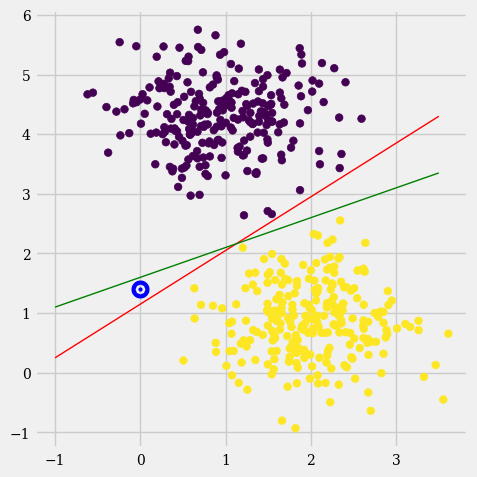

In [7]:
xfit = np.linspace(-1, 3.5)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(Xblobs[:, 0], Xblobs[:, 1], c=yblobs, s=30)
ax.plot([0], [1.4],'.', color='b', markeredgewidth=10)

for m, b,c  in [(0.9, 1.15,'red'), (0.5, 1.6,'green')]:
    ax.plot(xfit, m * xfit + b, c)
plt.tight_layout()

Suivant le modèle retenu, le point bleu sera alors affecté à l'une ou l'autre des classes. On se pose alors la question : quel est le meilleur séparateur linéaire possible dans ce cas ? 

Les SVM apportent une réponse, en traçant autour de chaque séparateur une région, définie par une marge, et ne contenant aucun point de données. Le meilleur classifieur sera celui possédant la marge la plus large (en français SVM a été traduit par "Séparateur à Vaste Marge")

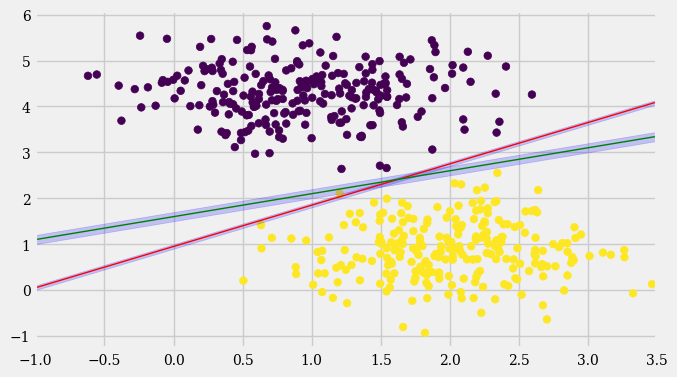

In [8]:
xfit = np.linspace(-1, 3.5)
plt.scatter(Xblobs[:, 0], Xblobs[:, 1], c=yblobs, s=30)

for m, b, c, d in [(0.9, 0.95, 'red',0.05), (0.5, 1.6, 'green',0.1)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, c)
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='b', alpha=0.2)

plt.xlim(-1, 3.5);
plt.tight_layout()

<a name='marge'></a>

## SVM et classification vaste marge


In [9]:
from sklearn.svm import SVC

svm_clf = SVC(kernel="linear", C=1E10)
svm_clf.fit(Xblobs, yblobs);

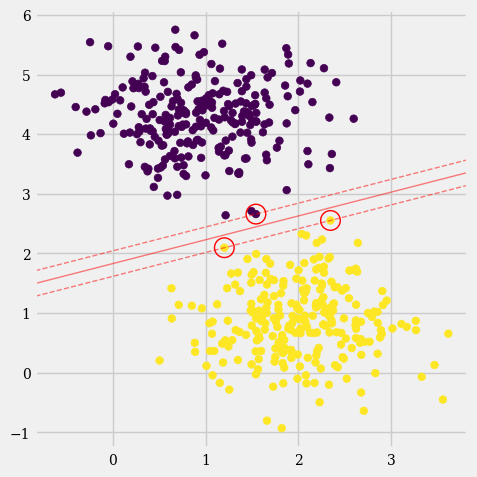

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(Xblobs[:, 0], Xblobs[:, 1], c=yblobs, s=30)
plot_svc_frontiere(svm_clf);

plt.tight_layout()

Les points de données cerclés sont les vecteurs supports, et définissent le séparateur linéaire. 

## Violation de la marge et effets de la régularisation (paramètre C)


Par exemple dans le cas de données linéairement séparables on a 

In [11]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

svm_clf = Pipeline([("scaler", StandardScaler()),
                    ("linear_svc", LinearSVC(C=1, loss="hinge", random_state=42)),])

svm_clf.fit(Xblobs, yblobs);

Classification avec deux paramètres différentes de régularisation

In [12]:
scaler = StandardScaler()

# SVM linéaire avec fonction de perte charnière  et deux paramètres de régularisation différents
svm_clf1 = LinearSVC(C=1, loss="hinge", random_state=42)
svm_clf2 = LinearSVC(C=100, loss="hinge", random_state=42)

# Classification avec variables normalisés.
scaled_svm_clf1 = Pipeline([("scaler", scaler),("linear_svc", svm_clf1),])
scaled_svm_clf2 = Pipeline([("scaler", scaler),("linear_svc", svm_clf2),])

scaled_svm_clf1.fit(Xblobs, yblobs)
scaled_svm_clf2.fit(Xblobs, yblobs);


In [13]:
# Conversion aux paramètres non normalisés
b1 = svm_clf1.decision_function([-scaler.mean_ / scaler.scale_])
b2 = svm_clf2.decision_function([-scaler.mean_ / scaler.scale_])
w1 = svm_clf1.coef_[0] / scaler.scale_
w2 = svm_clf2.coef_[0] / scaler.scale_
svm_clf1.intercept_ = np.array([b1])
svm_clf2.intercept_ = np.array([b2])
svm_clf1.coef_ = np.array([w1])
svm_clf2.coef_ = np.array([w2])

# Vecteurs support
t = yblobs * 2 - 1
support_vectors_idx1 = (t * (Xblobs.dot(w1) + b1) < 1).ravel()
support_vectors_idx2 = (t * (Xblobs.dot(w2) + b2) < 1).ravel()
svm_clf1.support_vectors_ = Xblobs[support_vectors_idx1]
svm_clf2.support_vectors_ = Xblobs[support_vectors_idx2]


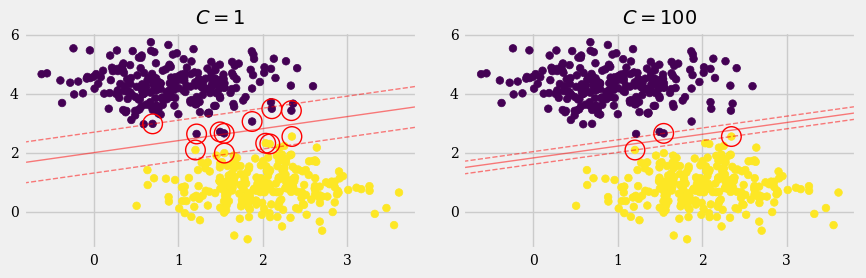

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(9, 3))
ax[0].scatter(Xblobs[:, 0], Xblobs[:, 1], c=yblobs, s=30)
plot_svc_frontiere(svm_clf1,ax=ax[0])
ax[0].set_title("$C = {}$".format(svm_clf1.C), fontsize=14)

ax[1].scatter(Xblobs[:, 0], Xblobs[:, 1], c=yblobs, s=30)
plot_svc_frontiere(svm_clf2,ax=ax[1])
ax[1].set_title("$C = {}$".format(svm_clf2.C), fontsize=14)

plt.tight_layout()

## Cas multiclasses

Deux stratégies sont possibles dans le cas multiclasse : 
- un contre tous : transformer le problème à $k$ classes en $k$ classifieurs binaires, la classe de l'exemple est donnée par le classifieur qui répond le mieux
- un contre un : transformer le problème en $\frac{k(k-1)}{2}$ classifieurs binaires, chaque classe étant comparée aux autres. La classe de l'exemple est donnée par le vote majoritaire ou par un graphe acyclique de décision

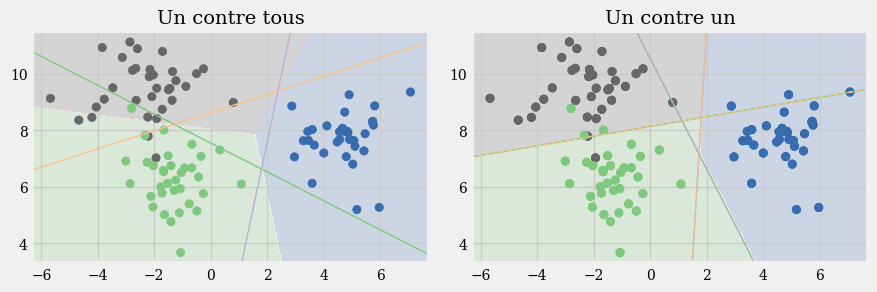

In [15]:

X, y = make_blobs(random_state=27)
colors = [plt.cm.Accent(i) for i in [0, 1, 2]]
fig, ax = plt.subplots(1, 2, figsize=(9, 3))

linear_svm = LinearSVC(C=100).fit(X, y)
points = ax[0].scatter(X[:, 0], X[:, 1], c=y, cmap="Accent")
xlim = ax[0].get_xlim()
ylim = ax[0].get_ylim()
ax[0].set_xlim(xlim)
ax[0].set_ylim(ylim)


xs = np.linspace(xlim[0], xlim[1], 1000)
ys = np.linspace(ylim[0], ylim[1], 1000)
xx, yy = np.meshgrid(xs, ys)
pred = linear_svm.predict(np.c_[xx.ravel(), yy.ravel()])
ax[0].imshow(pred.reshape(xx.shape), cmap="Accent", alpha=.2, 
           extent=(xlim[0], xlim[1], ylim[1], ylim[0]))
line = np.linspace(-15, 15)
for coef, intercept, color in zip(linear_svm.coef_, linear_svm.intercept_, colors):
    ax[0].plot(-(line * coef[1] + intercept) / coef[0], line, c=color)
ax[0].set_title("Un contre tous",fontsize=14)


classes = [(0, 1), (0, 2), (1, 2)]
svm = SVC(kernel="linear", C=100).fit(X, y)
points = ax[1].scatter(X[:, 0], X[:, 1], c=y, cmap="Accent")
xlim = ax[1].get_xlim()
ylim = ax[1].get_ylim()
ax[1].set_xlim(xlim)
ax[1].set_ylim(ylim)
points = ax[1].scatter(X[:, 0], X[:, 1], c=y, cmap="Accent")
pred = svm.predict(np.c_[xx.ravel(), yy.ravel()])
ax[1].imshow(pred.reshape(xx.shape), cmap="Accent", alpha=.2, 
           extent=(xlim[0], xlim[1], ylim[1], ylim[0]))
for coef, intercept, col in zip(svm.coef_, svm.intercept_, classes):
    line2 = -(line * coef[1] + intercept) / coef[0]
    ax[1].plot(line2, line, "-", c=colors[col[0]])
    ax[1].plot(line2, line, "--", c=colors[col[1]])
ax[1].set_title("Un contre un",fontsize=14)

plt.tight_layout()

